In [2]:
# Read data and aggregate into monthly sale_cnt

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(item_cnt_month=('item_cnt_day','sum')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')
shop_item_list = pd.unique(train_monthly_df['shop_item'])
print("cnt of shop_item:",len(shop_item_list))
train_monthly_df

cnt of shop_item: 424124


,date_block_num,shop_id,item_id,item_cnt_month,shop_item
0,0,0,32,6.0,0-32
1,0,0,33,3.0,0-33
2,0,0,35,1.0,0-35
3,0,0,43,1.0,0-43
4,0,0,51,2.0,0-51
...,...,...,...,...,...
1609119,33,59,22087,6.0,59-22087
1609120,33,59,22088,2.0,59-22088
1609121,33,59,22091,1.0,59-22091
1609122,33,59,22100,1.0,59-22100


In [3]:
# get the sequence of each shop_item

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    data_seq_dict[shop_item] = [0.0 for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])] = row['item_cnt_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print(data_seq_array)
print(data_seq_array.shape)

[[ 6. 10.  0. ...  0.  0.  0.]
 [ 3.  3.  0. ...  0.  0.  0.]
 [ 1. 14.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  0.  1.]]
(424124, 34)


In [4]:
# get the default sequence for items: calculate the average sale_cnt as default sequence for items

item_seq_dict = {}
item_seq_num_dict = {}
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = item_seq_dict[item] + v
        item_seq_num_dict[item] += 1
for item in item_seq_dict.keys():
    item_seq_dict[item] = [e / item_seq_num_dict[item] for e in item_seq_dict[item]]

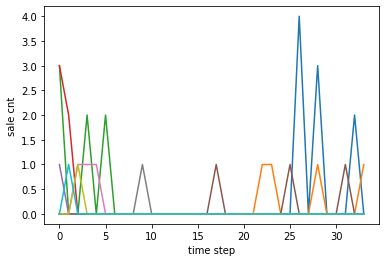

In [5]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(data_seq_array.shape[0])
np.random.shuffle(row_random_array)
row_random = data_seq_array[row_random_array[0:10]]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X = data_seq_array[:,0:-1]
Y = data_seq_array[:,1:]
X = X.reshape((X.shape[0], X.shape[1], 1))
Y = Y.reshape((Y.shape[0], Y.shape[1], 1))
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)

In [7]:
# LSTM

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()
model.add(LSTM(1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
model.summary()

model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=1024*256)

2022-11-10 09:25:04.639152: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 1)             12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


2022-11-10 09:25:05.689311: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2/2 [==============================] - 4s 925ms/step - loss: 2.9035 - root_mean_squared_error: 2.9188 - val_loss: 3.2699 - val_root_mean_squared_error: 3.2699
Epoch 2/10
2/2 [==============================] - 1s 324ms/step - loss: 2.8693 - root_mean_squared_error: 2.8978 - val_loss: 3.2659 - val_root_mean_squared_error: 3.2659
Epoch 3/10
2/2 [==============================] - 1s 345ms/step - loss: 2.8754 - root_mean_squared_error: 2.8934 - val_loss: 3.2627 - val_root_mean_squared_error: 3.2627
Epoch 4/10
2/2 [==============================] - 1s 356ms/step - loss: 2.8896 - root_mean_squared_error: 2.8900 - val_loss: 3.2600 - val_root_mean_squared_error: 3.2600
Epoch 5/10
2/2 [==============================] - 1s 328ms/step - loss: 2.8848 - root_mean_squared_error: 2.8870 - val_loss: 3.2576 - val_root_mean_squared_error: 3.2576
Epoch 6/10
2/2 [==============================] - 2s 595ms/step - loss: 2.8769 - root_mean_squared_error: 2.8844 - val_loss: 3.2555 - val_root_mean_sq

In [8]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    if shop_item in data_seq_dict.keys():
        X_test.append(data_seq_dict[shop_item])
    elif row['item_id'] in item_seq_dict.keys():
        X_test.append(item_seq_dict[row['item_id']])
        print(row['item_id'])
    else:
        X_test.append([0.0 for i in range(0,34)])
X_test = np.asarray(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test = X_test[:,1:,:]

In [9]:
pred = model.predict(X_test)

pred = pred[:,-1:,:]
pred = pred.reshape((pred.shape[0]))

In [10]:
submission_df = pd.DataFrame(pred, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,0.146179
1,0.155876
2,0.453169
3,0.157153
4,0.155876
...,...
214195,0.511313
214196,0.155876
214197,0.156423


In [11]:
submission_df.to_csv('/kaggle/working/submission.csv')